# Predicting Bitcoin Price with Social Media Activity and Streaming Machine Learning

One of the many interesting facts about cryptocurrencies is how much social media activity dominates the discourse and the price. In this article we are going to use the [Lunar Crush](https://lunarcrush.com/dashboard) API to get social media activity data along with market data for bitcoin. Then using this combination we will use online machine learning to build a model that can predict tomorrows bitcoin price!

First we have to setup our environment. The libaries are all common python libraries, except for [River Machine Learning](https://riverml.xyz/latest/). River allows us to train a model on a stream of data incrementally, so it is constantly learning as new data is available. In theory streaming (or online) machine learning can be much more effective than standard batch machine learning, especially when dealing with data that may exhibit drift. A streaming approach should be able to adapt better than a batch based method. Given the dynmic and turbulent nature of crypto currencies this should be ideal for streaming ML.

In [1]:
import json
import random
import requests

import pandas as pd
import matplotlib.pyplot as plt

from river import compose, linear_model, preprocessing, feature_selection, stats

### Download The Data

In order to get data from Lunar Crush you have to sign up for an account (it's free), but then you can generate an API key allowing you to connect to the REST endpoint. Now to query the REST endpoint all you have to do is generate the URL for your query and specify the fields required. Full details can be found on the API documentation page [here](https://lunarcrush.com/developers/docs). In this case we are looking for the last 200 days worth of data for Bitcoin and looking for data with an interval of a day.

In [2]:
api_key = "<api-token-here>"
query_url = f"https://api.lunarcrush.com/v2?data=assets&key={api_key}&symbol=BTC&data_points=200&interval=day"
with requests.get(query_url) as r:
    if r.ok:
        data = json.loads(r.content)

### Get the Data Ready for Machine Learning

The data is returned as a json object with a range of fields. In this case we are only interested in the `timeSeries` field within the `data` field. This is a python list of dictionaries, these can easily be converted into a pandas dataframe. The time can easily be converted to python datetime type, as it is seconds since epoch.

There are over 50 columns returned from Lunar Crush, which is quite a few and could easily cause issues if they are all passed into any ML model. To remove a few columns to start with lets remove any columns containing `NaNs` and any columns with low cardinality.

Importantly we need to add a target variable to learn from. In this case we are going to use the closing price for the next day. This can easily be done using the pandas `shift` function, consequently we do need to remove the last row as this includes a target of `Nan`.

In [3]:
df = pd.DataFrame.from_records(data['data'][0]['timeSeries'])
df['time'] = pd.to_datetime(df['time'], unit='s')

In [4]:
cols_to_keep = [col for col in df.columns if df[col].isna().sum()/len(df) == 0 and df[col].nunique() > int(len(df)*0.1)]
df = df[cols_to_keep] 

In [5]:
df['target'] = df['close'].shift(-1) - df['close']
df = df.dropna()

In [6]:
df[['time', 'open', 'close', 'volume', 'reddit_posts', 'tweets', 'social_contributors', 'social_volume', 'target']].tail()

,time,open,close,volume,reddit_posts,tweets,social_contributors,social_volume,target
194,2021-05-05,54484.401899,57510.899418,87836031241,2026,261638,173104,291791,-1043.223284
195,2021-05-06,57365.355791,56467.676133,81668273343,2019,230341,189607,256108,888.759244
196,2021-05-07,56423.026492,57356.435377,81688463407,2144,259285,178775,289636,1684.688564
197,2021-05-08,59847.384135,59041.123941,80774105610,2071,221721,187309,250042,-725.715139
198,2021-05-09,59055.293226,58315.408802,80874583929,2407,213873,153760,238963,-1451.043310


### A Quick Simple Model

Before we get carried away with machine learning lets get an idea for a simple streaming model. The simpliest model I can think of is simply to predict tomorrows change as the change observed today. Quick note `1` represents the price going up and `-1` the price going down. We can start with a random direction.

In [7]:
yesterdays_direction = random.choice([1, -1])

all_results = []
for i, row in df.iterrows():
    todays_observed_change = row['close'] - row['open']
    todays_result = todays_observed_change * yesterdays_direction
    all_results.append({'Date': row['time'], 'Profit': todays_result})
    yesterdays_direction = 1 if todays_observed_change >=0 else -1    

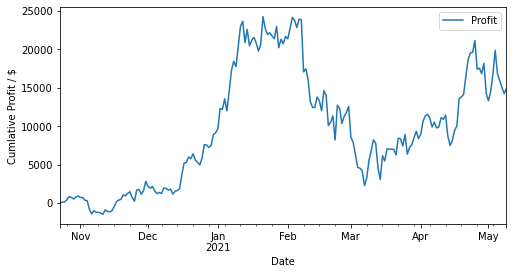

In [8]:
df_simple = pd.DataFrame.from_records(all_results)
fig, ax = plt.subplots(figsize=(8,4))
df_simple.set_index(df_simple['Date']).drop(columns='Date').cumsum().plot(ax=ax)
ax.set_ylabel('Cumlative Profit / $');

In [9]:
simple_wins = dict(df_simple['Profit'].apply(lambda x: 1 if x >=0 else -1).value_counts())
print(f"Win rate: {100*simple_wins[1]/(sum(simple_wins.values())):.2f}%")

Win rate: 53.77%


From this even a very simple model does show some possibilty of predicting the future! But can we do better with streaming machine learning?

### Streaming Machine Learning

In order to create a model using river we can create a `Pipeline` to link together multiple operations. Initially we will scale the features using the `StandardScaler` to ensure all features have zero mean and unit variance. One problem mentioned earlier are the large number of features, in order to reduce this we can use `SelectKBest` to down select to a much smaller number of features. Then finally a simple `LinearRegression` model to do the actual prediction.

In [10]:
model = compose.Pipeline(
    preprocessing.StandardScaler(),
    feature_selection.SelectKBest(similarity=stats.PearsonCorr(), k=10),
    linear_model.LinearRegression())

In order to run the model we can iterate through the dataframe in time order using the current days inputs to predict tomorrows closing price. Then we can use the actual result to train the model. 

In [11]:
feature_cols = [col for col in df.columns if col not in ["time", 'target']]
results = []
for i, row in df.iterrows():
    X = dict(row[feature_cols])
    y = row['target']
    
    y_pred = model.predict_one(X)
    model = model.learn_one(X, y)
    
    predicted_direction = 1 if y_pred >=0 else -1 
    daily_profit = predicted_direction * y
    
    results.append({'Date': row['time'], 'Profit':daily_profit})

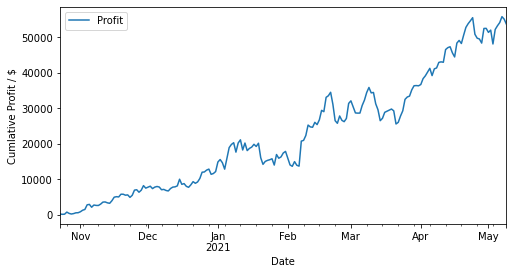

In [12]:
df_online = pd.DataFrame.from_records(results)
fig, ax = plt.subplots(figsize=(8,4))
df_online.set_index(df_online['Date']).drop(columns='Date').cumsum().plot(ax=ax);
ax.set_ylabel('Cumlative Profit / $');

In [13]:
simple_wins = dict(df_online['Profit'].apply(lambda x: 1 if x >=0 else -1).value_counts())
print(f"Win rate: {100*simple_wins[1]/(sum(simple_wins.values())):.2f}%")

Win rate: 64.32%


A correct prediction rate of around 64 % is not too bad and is a clear improvement over a very simple model. The cumlative profit plot shows an approximately linear beavhiour, which suggests this model has performed well throughout, where as the simple model clearly had its ups and downs. There should be plenty of room for improvement, especially as there has been no 
tuning of any model parameters. 

Overall hopefully this highlihts powerful streaming machine learning can be and especially how it can handle volatile data!